# Preliminary Work

Let's check for multicollinearity and make sure to drop 1 dummy from each category.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import stats
import statsmodels.stats.api as sms

sns.set_style('darkgrid')

In [2]:
# importing data
df = pd.read_csv('csv_files/new_kc_house_data_clean_with_dummies2.csv')
df = df.drop(['Unnamed: 0','id'], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,...,grd_12_to_13,jan_mar,apr_jun,jul_sep,oct_dec,cond_poor,cond_fair,cond_average,cond_good,cond_very_good
0,221900.0,3,1.00,1180,5650,1180,55,66,47.5112,-122.257,...,0,0,0,0,1,0,0,1,0,0
1,205425.0,2,1.00,880,6780,880,45,66,47.5009,-122.248,...,0,0,1,0,0,0,0,0,1,0
2,445000.0,3,2.25,2100,8201,1620,67,66,47.5091,-122.244,...,0,0,0,1,0,0,0,1,0,0
3,236000.0,3,1.00,1300,5898,1300,61,66,47.5053,-122.255,...,0,0,0,1,0,0,0,1,0,0
4,170000.0,2,1.00,860,5265,860,31,66,47.5048,-122.272,...,0,1,0,0,0,0,0,1,0,0


In [3]:
# label encode city column
df['city'] = df['city'].astype('category')
df['city'] = df.city.cat.codes

## Checking for Multicollinearity

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21420 non-null  float64
 1   bedrooms         21420 non-null  int64  
 2   bathrooms        21420 non-null  float64
 3   sqft_living      21420 non-null  int64  
 4   sqft_lot         21420 non-null  int64  
 5   sqft_above       21420 non-null  int64  
 6   yr_built         21420 non-null  int64  
 7   zipcode          21420 non-null  int64  
 8   lat              21420 non-null  float64
 9   long             21420 non-null  float64
 10  sqft_living15    21420 non-null  int64  
 11  sqft_lot15       21420 non-null  int64  
 12  waterfront_N     21420 non-null  int64  
 13  waterfront_Y     21420 non-null  int64  
 14  not_renovated    21420 non-null  int64  
 15  is_renovated     21420 non-null  int64  
 16  floors_1         21420 non-null  int64  
 17  floors_2    

<AxesSubplot:>

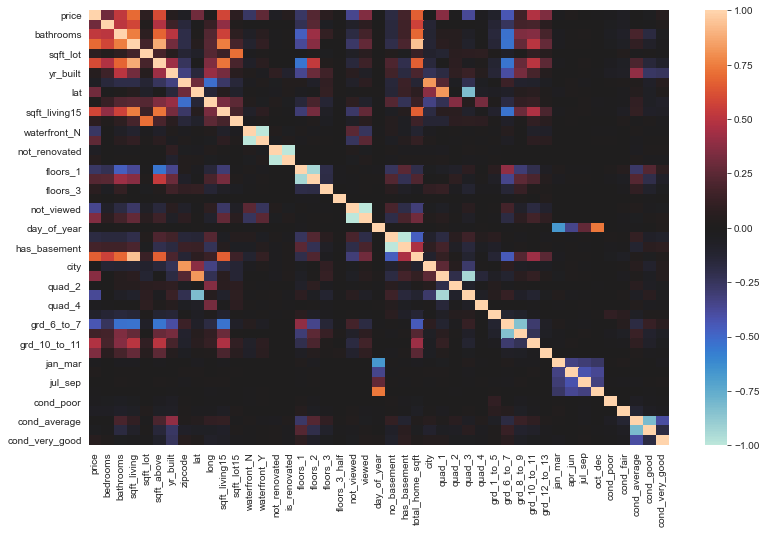

In [5]:
# checking heatmap for new correlations 
fig = plt.figure(figsize=(13,8))
sns.heatmap(data=df.corr(), center=0)

In [6]:
# creating a date frame that only contains the pairs of values with highest 
# correlation

# converts all elements to absolute values, stacks into multi-index, resets 
# the index to set the multi-index to seperate columns, and finally sorts them
corr_pairs = df.corr().abs().stack().reset_index().sort_values(0, 
                                                                ascending=False)
# zipping the variable name columns
corr_pairs['pairs'] = list(zip(corr_pairs.level_0, corr_pairs.level_1))

#set index to the pairs
pairs_index = corr_pairs.set_index(['pairs'])

#dropping level columns
pairs = pairs_index.drop(columns=['level_0', 'level_1'])

#renaming column for comprehension
pairs.columns = ['correlation']
#Since our heatmap shows that our variables only show perfect correlation with 
#themselves, we'll drop duplicates
unique_pairs = pairs.drop_duplicates()

In [7]:
unique_pairs[(unique_pairs.correlation>0.75) & (unique_pairs.correlation<1)]

,correlation
pairs,
"(total_home_sqft, sqft_living)",0.941129
"(quad_3, quad_1)",0.934385
"(floors_2, floors_1)",0.929959
"(sqft_above, sqft_living)",0.876533
"(grd_8_to_9, grd_6_to_7)",0.836263
"(quad_3, lat)",0.826516
"(zipcode, city)",0.825704
"(lat, quad_1)",0.821455
"(cond_good, cond_average)",0.813095


In [8]:
# making a list of items to drop
to_drop = ['price','sqft_living','floors_2','grd_8_to_9','cond_good',
           'has_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated', 'city', 'quad_3']

X = ['sqft_living','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated', 'city', 'quad_3']

# Modeling

In [9]:
target = 'price'

feats = df.drop(to_drop, axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Ordinary least squares
=========================================================================================
Model:                     OLS                     Adj. R-squared:            0.726      
Dependent Variable:        price                   AIC:                       582102.4372
Date:                      2021-03-02 15:26        BIC:                       582373.4879
No. Observations:          21420                   Log-Likelihood:            -2.9102e+05
Df Model:                  33                      F-statistic:               1717.      
Df Residuals:              21386                   Prob (F-statistic):        0.00       
R-squared:                 0.726                   Scale:                     3.7074e+10 
-----------------------------------------------------------------------------------------
                    Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
-----------------------------------------------------------------------------------------
Intercept       -41436035.7497 2033483.9014 -20.3769 0.0000 -45421816.5391 -37450254.9604
bedrooms           -24768.1620    1856.2973 -13.3428 0.0000    -28406.6438    -21129.6802
bathrooms           46372.3801    3123.2196  14.8476 0.0000     40250.6357     52494.1245
sqft_lot                0.1456       0.0460   3.1683 0.0015         0.0555         0.2357
sqft_above            108.1922       4.3892  24.6498 0.0000        99.5891       116.7953
yr_built            -1865.9189      67.2610 -27.7415 0.0000     -1997.7555     -1734.0823
zipcode             -1586.8832      88.9459 -17.8410 0.0000     -1761.2238     -1412.5425
lat                174770.3230   18156.8824   9.6256 0.0000    139181.4731    210359.1728
long              -272343.6825   14707.2432 -18.5177 0.0000   -301170.9810   -243516.3839
sqft_living15          43.4919       3.3148  13.1206 0.0000        36.9947        49.9891
sqft_lot15             -0.3126       0.0703  -4.4456 0.0000        -0.4504        -0.1748
waterfront_Y       682860.7344   16615.0680  41.0989 0.0000    650293.9565    715427.5124
is_renovated        14082.3589    3254.9421   4.3265 0.0000      7702.4286     20462.2892
floors_1              828.7911    3599.7007   0.2302 0.8179     -6226.8919      7884.4741
floors_3            65157.5006    7641.2712   8.5270 0.0000     50180.0366     80134.9646
floors_3_half       88152.2996   72921.6702   1.2089 0.2267    -54779.6372    231084.2363
viewed             107451.0195    5012.1208  21.4382 0.0000     97626.8873    117275.1518
day_of_year          -123.1384      51.4055  -2.3954 0.0166      -223.8970       -22.3797
no_basement          2224.1234    5027.9031   0.4424 0.6582     -7630.9433     12079.1901
total_home_sqft        72.3653       2.9921  24.1857 0.0000        66.5006        78.2300
quad_1             176380.1044    5570.1713  31.6651 0.0000    165462.1513    187298.0576
quad_2             142878.6099   11404.1269  12.5287 0.0000    120525.6668    165231.5530
quad_4             188996.6437   14875.8452  12.7049 0.0000    159838.8727    218154.4147
grd_1_to_5         -73981.7899   12963.6189  -5.7069 0.0000    -99391.4541    -48572.1256
grd_6_to_7         -55305.8026    3666.6236 -15.0836 0.0000    -62492.6595    -48118.9457
grd_10_to_11       228459.0635    6388.5311  35.7608 0.0000    215937.0640    240981.0630
grd_12_to_13       935149.9187   21021.3826  44.4857 0.0000    893946.4339    976353.4036
apr_jun              8357.1042    5679.8209   1.4714 0.1412     -2775.7702     19489.9786
jul_sep              1438.6994    9681.6101   0.1486 0.8819    -17537.9818     20415.3806
oct_dec             11192.1137   14082.9384   0.7947 0.4268    -16411.5007     38795.7281
cond_poor         -113451.1853   36714.4955  -3.0901 0.0020   -185414.3469    -41488.0236
cond_fair          -43441.8412   15434.5337  -2.8146 0.0049    -73694.6835    -13188.9988
cond_average       -

In [10]:
# importing train_test_split
y = df['price']
x_cols = df.drop(to_drop, axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [11]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

14994 6426 14994 6426


In [12]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [13]:
#calculating the Mean Squared error
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 37110963043.202034
Test Mean Squarred Error: 37092277664.27386


In [14]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 192642.05938268526
Test RMSE: 192593.55561459958


We've got a few things that aren't statistically significant, especially our variables for seasons.  Day of year, however, still has a low p-value, which is interesting.  Our Test RMSE is lower than our Training RMSE which is nice to see, but there is a bit of a difference between the two, in addition the overall RMSE being very large.

In [15]:
# dropping statistically insignificant features
to_drop = to_drop + ['no_basement', 'floors_3_half', 'jul_sep', 'oct_dec']

X = ['sqft_living','city','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated','floors_3_half','apr_jun','jul_sep','oct_dec',
           'quad_3']

## Baseline Model

In [16]:

target = 'price'

feats = df.drop(to_drop, axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Ordinary least squares
=========================================================================================
Model:                     OLS                     Adj. R-squared:            0.726      
Dependent Variable:        price                   AIC:                       582099.8446
Date:                      2021-03-02 15:26        BIC:                       582339.0070
No. Observations:          21420                   Log-Likelihood:            -2.9102e+05
Df Model:                  29                      F-statistic:               1954.      
Df Residuals:              21390                   Prob (F-statistic):        0.00       
R-squared:                 0.726                   Scale:                     3.7077e+10 
-----------------------------------------------------------------------------------------
                    Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
-----------------------------------------------------------------------------------------
Intercept       -41444518.2790 2027926.1380 -20.4369 0.0000 -45419405.3938 -37469631.1643
bedrooms           -24718.5481    1855.6326 -13.3208 0.0000    -28355.7269    -21081.3692
bathrooms           46196.4254    3103.9992  14.8829 0.0000     40112.3544     52280.4963
sqft_lot                0.1457       0.0459   3.1715 0.0015         0.0557         0.2358
sqft_above            109.4673       3.3366  32.8085 0.0000       102.9274       116.0072
yr_built            -1865.2937      67.2593 -27.7329 0.0000     -1997.1269     -1733.4605
zipcode             -1589.2945      88.8537 -17.8866 0.0000     -1763.4545     -1415.1345
lat                174816.3678   18153.4249   9.6299 0.0000    139234.2954    210398.4403
long              -272387.1660   14647.7010 -18.5959 0.0000   -301097.7570   -243676.5750
sqft_living15          43.3017       3.3129  13.0707 0.0000        36.8082        49.7952
sqft_lot15             -0.3120       0.0703  -4.4371 0.0000        -0.4498        -0.1742
waterfront_Y       683182.4536   16609.4822  41.1321 0.0000    650626.6245    715738.2827
is_renovated        14011.6459    3254.7297   4.3050 0.0000      7632.1319     20391.1599
floors_1              836.5068    3598.8535   0.2324 0.8162     -6217.5155      7890.5292
floors_3            65175.4892    7624.1235   8.5486 0.0000     50231.6362     80119.3423
viewed             107541.5613    5009.8556  21.4660 0.0000     97721.8690    117361.2536
day_of_year           -87.9591      14.8879  -5.9081 0.0000      -117.1405       -58.7776
total_home_sqft        71.4394       2.1085  33.8817 0.0000        67.3066        75.5722
quad_1             176266.1101    5560.3597  31.7005 0.0000    165367.3886    187164.8316
quad_2             142751.0948   11396.7992  12.5255 0.0000    120412.5148    165089.6748
quad_4             188792.2588   14867.9392  12.6979 0.0000    159649.9845    217934.5330
grd_1_to_5         -73273.7873   12941.1149  -5.6621 0.0000    -98639.3417    -47908.2329
grd_6_to_7         -55280.7538    3664.3543 -15.0861 0.0000    -62463.1628    -48098.3449
grd_10_to_11       228466.9869    6388.1348  35.7643 0.0000    215945.7642    240988.2096
grd_12_to_13       936289.9373   21004.8220  44.5750 0.0000    895118.9130    977460.9616
apr_jun              6707.7471    3024.6877   2.2177 0.0266       779.1326     12636.3616
cond_poor         -112719.6489   36709.6951  -3.0706 0.0021   -184673.4006    -40765.8972
cond_fair          -43069.5706   15430.3978  -2.7912 0.0053    -73314.3060    -12824.8352
cond_average       -28561.6733    3334.0140  -8.5668 0.0000    -35096.5904    -22026.7562
cond_very_good      38279.6442    5426.7973   7.0538 0.0000     27642.7150     48916.5734
-----------------------------------------------------------------------------------------
Omnibus:                    16006.242            Durbin-Watson:               1.403      
Prob(Omnibus):      

Adjusted R-squared has dropped, but not by much. So we'll call this our baseline model. Let's check the change in RMSE and move on to tightening it up.

In [17]:
y = df['price']
x_cols = df.drop(to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [18]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [19]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 37126793425.56451
Test Mean Squarred Error: 37078427194.03025


In [20]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 192683.14255680103
Test RMSE: 192557.5944854688


Those values, were very insignificant, because there is little to no change in RMSE and overall fit.

Now lets look at the QQ-plot and checking for homoscedasticity 

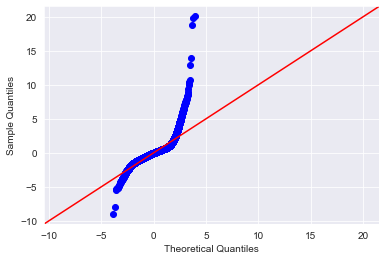

In [21]:
# Checking distribution  of errors using QQ-plot
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

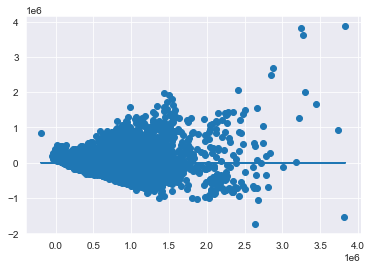

In [22]:
# Checking for homoscedasticity 

X = df.drop(to_drop, axis=1)

plt.scatter(model.predict(X), model.resid)
plt.plot(model.predict(X), [0 for i in range(len(df))])

Plot shows signs of **heteroscedasticity**. Residual errors are **not distributed normally**.

In [23]:
df1 = df.copy()

In [24]:
# before we go further, we'll create a new dataframe with all of the 
# insignificant values removed
X = ['sqft_living','city','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated','floors_3_half','apr_jun','jul_sep','oct_dec']

df1 = df1.drop(X, axis=1)

# Outliers

As we saw earlier, not only are our residuals not normal, but there are a lot of outliers. Lets trim them down.

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21420 non-null  float64
 1   bedrooms         21420 non-null  int64  
 2   bathrooms        21420 non-null  float64
 3   sqft_lot         21420 non-null  int64  
 4   sqft_above       21420 non-null  int64  
 5   yr_built         21420 non-null  int64  
 6   zipcode          21420 non-null  int64  
 7   lat              21420 non-null  float64
 8   long             21420 non-null  float64
 9   sqft_living15    21420 non-null  int64  
 10  sqft_lot15       21420 non-null  int64  
 11  waterfront_Y     21420 non-null  int64  
 12  is_renovated     21420 non-null  int64  
 13  floors_2         21420 non-null  int64  
 14  floors_3         21420 non-null  int64  
 15  viewed           21420 non-null  int64  
 16  day_of_year      21420 non-null  int64  
 17  has_basement

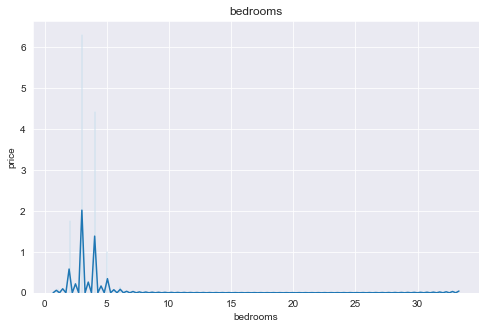

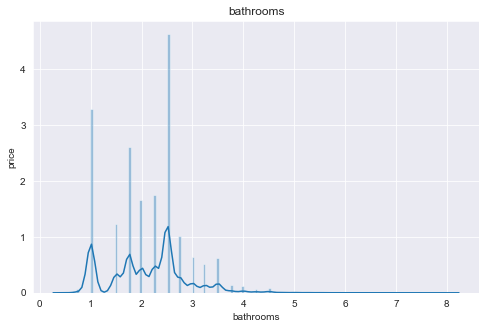

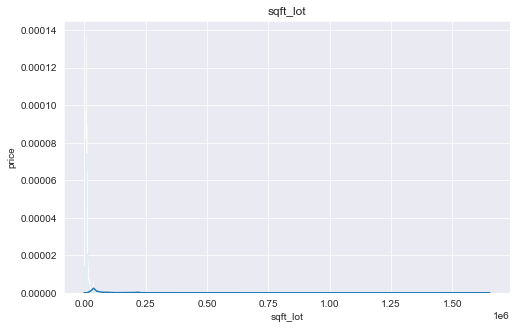

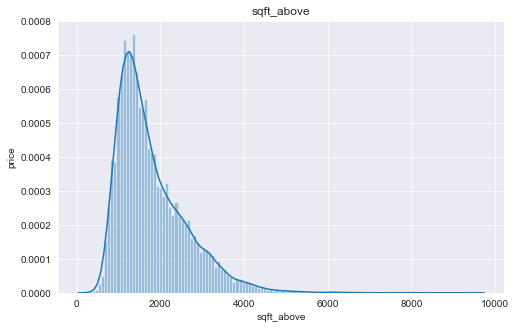

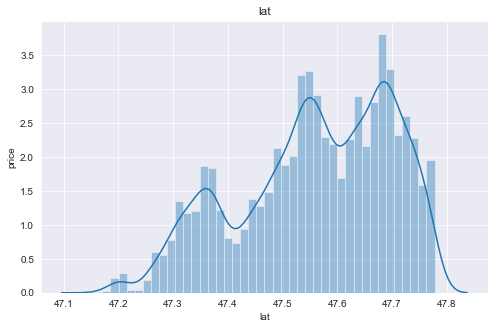

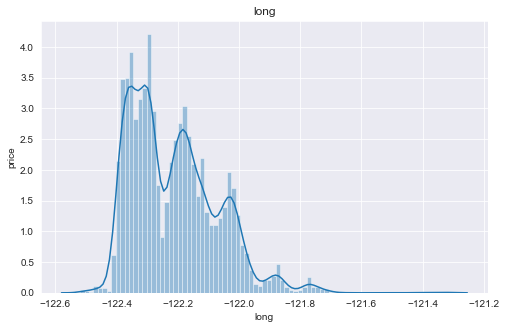

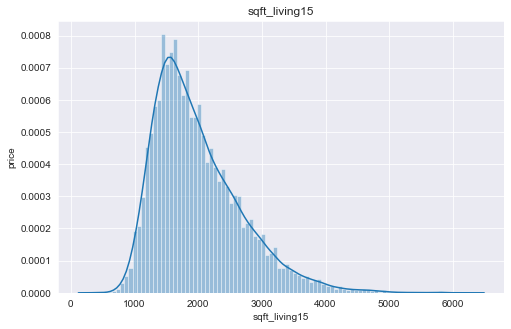

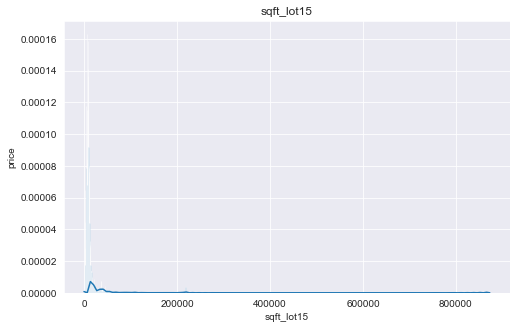

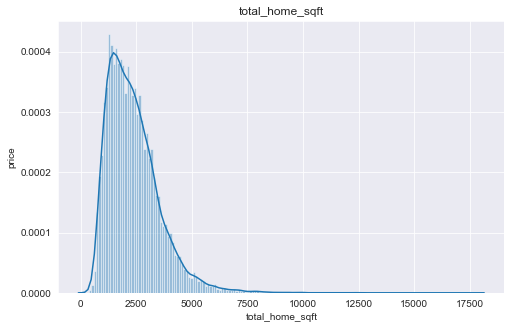

In [26]:
# We'll use a joint plot so we can also see the distribution of each feature
# as well as their relationship to the target
conts = df1[['price','bedrooms','bathrooms','sqft_lot','sqft_above','lat',
             'long','sqft_living15','sqft_lot15','total_home_sqft']]

no_price = conts.drop('price', axis=1)

for col in no_price.columns:
    plt.figure(figsize=(8,5))
    sns.distplot(conts[col], bins='auto')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')
    plt.show()

Identified the features to work on, so let's get to removing outliers

## Bedrooms

<AxesSubplot:xlabel='bedrooms'>

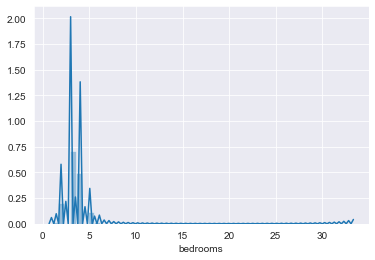

In [27]:
sns.distplot(df1['bedrooms'], kde=True)

In [28]:
# checking value counts
df1.bedrooms.value_counts()

3     9731
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [29]:
# checking out the stats of these houses that have 10 or more bedrooms
# Calling original data frame, before data was normalized 
mansion = df[df['bedrooms'] >= 10]
mansion.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,...,grd_12_to_13,jan_mar,apr_jun,jul_sep,oct_dec,cond_poor,cond_fair,cond_average,cond_good,cond_very_good
5368,640000.0,33,1.75,1620,6000,1040,47,42,47.6878,-122.331,...,0,0,1,0,0,0,0,0,0,1
11467,660000.0,10,3.00,2920,3745,1860,13,43,47.6635,-122.320,...,0,0,0,0,1,0,0,0,1,0
13598,1150000.0,10,5.25,4590,10920,2500,108,3,47.5861,-122.113,...,0,0,0,1,0,0,0,1,0,0
18364,650000.0,10,2.00,3610,11914,3010,58,5,47.5705,-122.175,...,0,0,0,0,1,0,0,0,1,0
20367,520000.0,11,3.00,3000,4960,2400,18,44,47.5560,-122.363,...,0,0,0,1,0,0,0,1,0,0


### Notes:
* The house with 33 bedrooms is clearly a **clerical error**.  A house with that is 2000 sq. ft. (with the basement) **cannot** have 33 bedrooms and 1.75 bathrooms.  The most likely explanation is human error and that this is actually a 3 bedroom home. As this is only a hypothesis, however, we'll just eliminate it along with anything else that has a z-score greater than 3. 

In [30]:
# using z-score to eliminate outliers 
df2 = df1.copy()
z = np.abs(stats.zscore(df2.bedrooms))
threshold = 3
df2 = df2[(z < 3)]

<AxesSubplot:xlabel='bedrooms'>

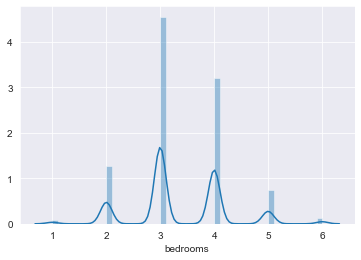

In [31]:
sns.distplot(df2['bedrooms'], label=col, kde=True)

Even though bedrooms can be considered discrete (a house can have as many rooms as the architect wants), you can make the argument that you can categorize houses by the number of bedrooms they have.  We'll change this to categorical.

In [32]:
# # Changing to categorical
# df2['bedrooms'] = df2['bedrooms'].astype('category')
# df2['bedrooms'] = df2.bedrooms.cat.codes

## Bathrooms

2.50    5349
1.00    3793
1.75    3019
2.25    2028
2.00    1912
1.50    1427
2.75    1176
3.00     738
3.50     723
3.25     584
3.75     152
4.00     126
4.50      94
4.25      77
0.75      70
4.75      21
5.00      20
5.25      12
5.50       9
1.25       9
6.00       5
0.50       4
5.75       3
6.50       2
6.25       2
8.00       1
7.75       1
6.75       1
Name: bathrooms, dtype: int64

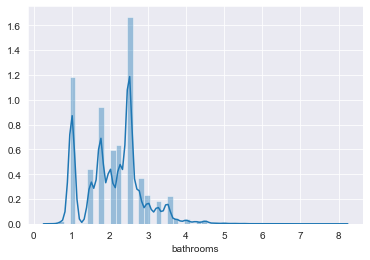

In [33]:
sns.distplot(df2['bathrooms'], label=col, kde=True)
df2.bathrooms.value_counts()

In [34]:
# We'll just do some trimming
df2 = df2[df2['bathrooms'] <= 4.00]

2.50    5349
1.00    3793
1.75    3019
2.25    2028
2.00    1912
1.50    1427
2.75    1176
3.00     738
3.50     723
3.25     584
3.75     152
4.00     126
0.75      70
1.25       9
0.50       4
Name: bathrooms, dtype: int64

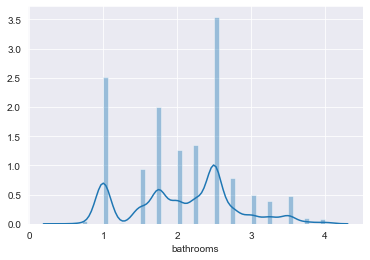

In [35]:
sns.distplot(df2['bathrooms'], label=col, kde=True)
df2.bathrooms.value_counts()

In [36]:
# # Changing to categorical
# df2['bathrooms'] = df2['bathrooms'].astype('category')
# df2['bathrooms'] = df2.bathrooms.cat.codes

## Total_home_sqft

count    21110.000000
mean      2322.399526
std       1090.115409
min        370.000000
25%       1490.000000
50%       2150.000000
75%       2940.000000
max      10500.000000
Name: total_home_sqft, dtype: float64

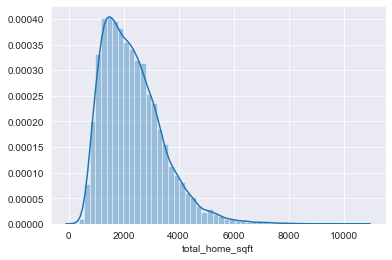

In [37]:
sns.distplot(df2['total_home_sqft'], label=col, kde=True)
df2.total_home_sqft.describe()

In [38]:
# We'll use the z-score again, but this data is pretty normal (thankfully)
z = np.abs(stats.zscore(df2.total_home_sqft))
threshold = 3
df2 = df2[(z < 3)]

<AxesSubplot:xlabel='total_home_sqft'>

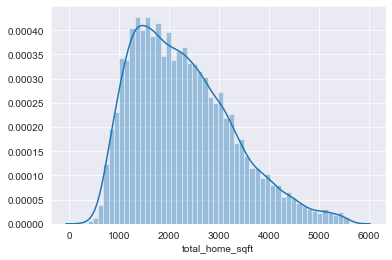

In [39]:
sns.distplot(df2['total_home_sqft'], label=col, kde=True)

## Sqft_lot

array([ 5650,  6780,  8201, ..., 16684, 18115, 18713], dtype=int64)

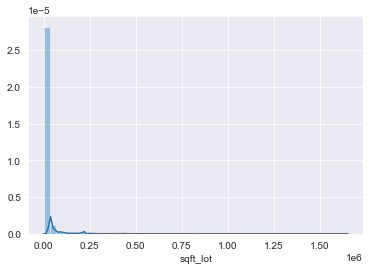

In [40]:
sns.distplot(df2['sqft_lot'], label=col, kde=True)
df2.sqft_lot.unique()

In [41]:
z = np.abs(stats.zscore(df2.sqft_lot))
threshold = 3
df2 = df2[(z < 3)]

It's a marked improvement, but if this graph represents 3 standard deviations, it might be worth dropping entirely

## Sqft_lot15

count     20562.000000
mean      10317.830902
std       15650.489569
min         651.000000
25%        5038.000000
50%        7508.000000
75%        9826.750000
max      434728.000000
Name: sqft_lot15, dtype: float64

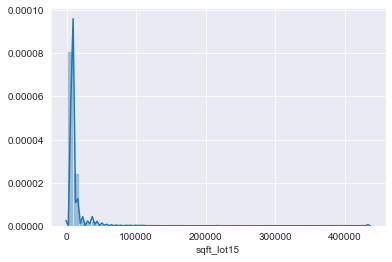

In [42]:
sns.distplot(df2['sqft_lot15'], label=col, kde=True)
df2.sqft_lot15.describe()

In [43]:
z = np.abs(stats.zscore(df2.sqft_lot15))
threshold = 3
df2 = df2[(z < 3)]

count    20287.000000
mean      8965.116133
std       7657.387711
min        651.000000
25%       5000.000000
50%       7500.000000
75%       9724.000000
max      57140.000000
Name: sqft_lot15, dtype: float64

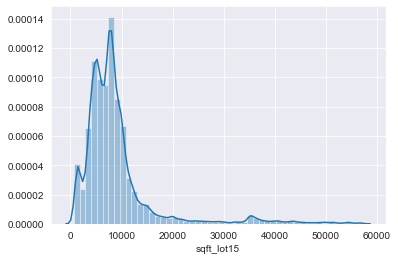

In [44]:
sns.distplot(df2['sqft_lot15'], label=col, kde=True)
df2.sqft_lot15.describe()

## Log Transformation

These plots still look pretty non-normal, so let's perform a log transformation and see if we can improve this.

In [45]:
# creating a new data frame for the log transformations
# bedrooms and 
log_df = df2.copy()
log_df = log_df.rename({'sqft_lot': 'log_sqft_lot',
                     'sqft_above':'log_sqft_above',
                     'total_home_sqft':'log_total_home_sqft',
                      'sqft_living15':'log_sqft_living15',
                      'sqft_lot15':'log_sqft_lot15'}, axis=1)

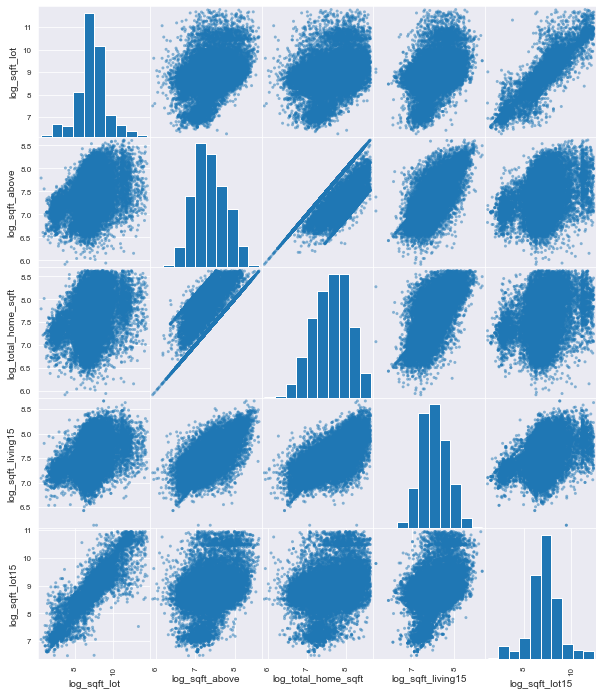

In [46]:
#transforming 
revised_logs = ['log_sqft_lot','log_sqft_above','log_total_home_sqft',
                'log_sqft_living15','log_sqft_lot15']

for log in revised_logs:
    log_df[log] = log_df[log].map(lambda x : np.log(x))
    log_df[log] = log_df[log].rename({log : 'log_'+log})
pd.plotting.scatter_matrix(log_df[revised_logs], figsize=(10,12));

In [47]:
conts = ['log_sqft_lot','log_sqft_above','log_total_home_sqft',
                'log_sqft_living15','log_sqft_lot15']

In [48]:
def norm_feat(series):
    """
    Input a series containing continuous variables.
    Outputs a normalized version of the data
    """
    return (series - series.mean())/series.std()

for feat in conts:
    log_df[feat] = norm_feat(log_df[feat])

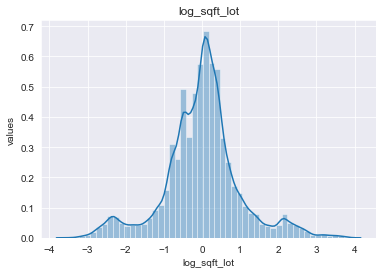

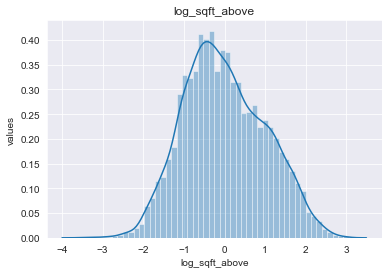

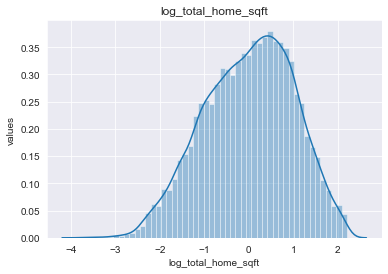

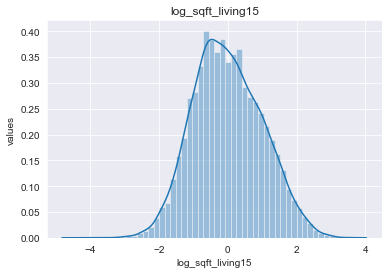

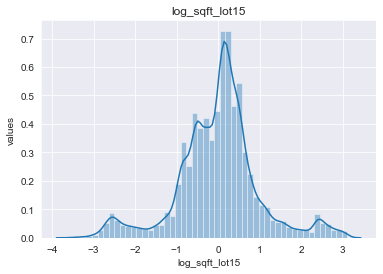

In [49]:
for col in conts: 
    sns.distplot(log_df[col], label=[col])
    plt.xlabel(col)
    plt.ylabel('values')
    plt.title(col)
    plt.show()

They look...interesting...but let's model it and calculate the RMSE.

In [50]:
target = 'price'

feats = log_df.drop('price', axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=log_df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                       OLS                      Adj. R-squared:             0.693      
Dependent Variable:          price                    AIC:                        544902.9976
Date:                        2021-03-02 15:27         BIC:                        545148.4474
No. Observations:            20287                    Log-Likelihood:             -2.7242e+05
Df Model:                    30                       F-statistic:                1527.      
Df Residuals:                20256                    Prob (F-statistic):         0.00       
R-squared:                   0.693                    Scale:                      2.7033e+10 
---------------------------------------------------------------------------------------------
                        Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------------
Intercept           -31470024.3158 1826037.8031 -17.2340 0.0000 -35049206.5123 -27890842.1193
bedrooms               -12151.2314    1821.6862  -6.6703 0.0000    -15721.8840     -8580.5787
bathrooms               42878.2483    2933.2162  14.6182 0.0000     37128.9066     48627.5901
log_sqft_lot            -2158.9588    2939.8855  -0.7344 0.4627     -7921.3728      3603.4553
log_sqft_above          90297.1525    3604.9798  25.0479 0.0000     83231.0997     97363.2053
yr_built                -1889.8198      60.4056 -31.2855 0.0000     -2008.2197     -1771.4200
zipcode                 -1203.7321      78.3314 -15.3672 0.0000     -1357.2680     -1050.1962
lat                    167349.7029   16135.4542  10.3716 0.0000    135722.9040    198976.5018
long                  -197362.2604   13365.1202 -14.7670 0.0000   -223558.9800   -171165.5407
log_sqft_living15       41832.0846    1955.8642  21.3880 0.0000     37998.4322     45665.7370
log_sqft_lot15          -7992.4980    2880.2358  -2.7749 0.0055    -13637.9937     -2347.0023
waterfront_Y           590228.5021   16524.9372  35.7174 0.0000    557838.2848    622618.7193
is_renovated            15833.2190    2855.8770   5.5441 0.0000     10235.4685     21430.9694
floors_2                -8688.2045    3466.2554  -2.5065 0.0122    -15482.3461     -1894.0628
floors_3                25226.6555    7726.4447   3.2650 0.0011     10082.1973     40371.1138
viewed                 112818.5759    4536.1368  24.8711 0.0000    103927.3798    121709.7719
day_of_year              -104.0418      12.2274  -8.5089 0.0000      -128.0086       -80.0750
has_basement            45693.8515    5386.8405   8.4825 0.0000     35135.2072     56252.4959
log_total_home_sqft     13744.7932    3639.1441   3.7769 0.0002      6611.7756     20877.8109
quad_1                 109850.0288   95072.4408   1.1554 0.2479    -76499.6662    296199.7237
quad_2                  73475.2374   95540.3725   0.7690 0.4419   -113791.6415    260742.1163
quad_3                 -65506.1931   95049.2090  -0.6892 0.4907   -251810.3519    120797.9656
quad_4                 115220.9746   95991.4316   1.2003 0.2300    -72930.0167    303371.9659
grd_1_to_5             -60529.2626   11634.3091  -5.2027 0.0000    -83333.4521    -37725.0732
grd_6_to_7             -73207.5496    3266.7602 -22.4098 0.0000    -79610.6644    -66804.4347
grd_10_to_11           280597.3534    5680.0745  49.4003 0.0000    269463.9467    291730.7602
grd_12_to_13           713601.1318   27836.4755  25.6355 0.0000    659039.3822    768162.8815
cond_poor             -101669.5756   31964.6455  -3.1807 0.0015   -164322.8732    -39016.2779
cond_fair              -45063.9232   13925.0057  -3.2362 0.0012    -72358.0638    -17769.7826
cond_average           -29835.4332    2933.7916 -10.1696 0.0000    -35585.9027    -24084.9637
cond_very_good          42428.9852

In [51]:
y = log_df['price']
x_cols = log_df.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [52]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [53]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 27194612728.710274
Test Mean Squarred Error: 26587106450.417664


In [54]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 164907.8916507948
Test RMSE: 163055.53179949973


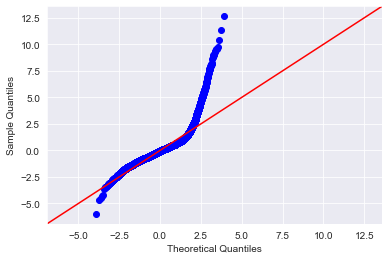

In [55]:
# Checking distribution  of errors using QQ-plot
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

### Initial Analysis

So far we can see that the RMSE for both the test and training data sets are relatively close.  So we know that so far, the model (despite its flaws) is not over trained.  It still has an root mean squared error of 165,000.  This isn't great, but it is not horrible in context. Given the price range of the data we're dealing with (between 78,000-3.4 million), being off by 165,000 isn't too bad on the higher end of the spectrum.  It does make it a poor estimator of lower prices.  This is could be due to the fact that there was still great deal of outliers in our residual errors, even after trimming them down. It could also be due to the fact that the residuals also don't follow a normal distribution.  

Before we commit to this, let's see if we can improve our model any further through step-wise selection.

# Step-Wise Selection

In [92]:
# Using step-wise selection to eliminate any remaining statistically 
# insignificant features based on their p-values

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [93]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20287 entries, 0 to 21419
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                20287 non-null  float64
 1   bedrooms             20287 non-null  int64  
 2   bathrooms            20287 non-null  float64
 3   log_sqft_lot         20287 non-null  float64
 4   log_sqft_above       20287 non-null  float64
 5   yr_built             20287 non-null  int64  
 6   zipcode              20287 non-null  int64  
 7   lat                  20287 non-null  float64
 8   long                 20287 non-null  float64
 9   log_sqft_living15    20287 non-null  float64
 10  log_sqft_lot15       20287 non-null  float64
 11  waterfront_Y         20287 non-null  int64  
 12  is_renovated         20287 non-null  int64  
 13  floors_2             20287 non-null  int64  
 14  floors_3             20287 non-null  int64  
 15  viewed               20287 non-null 

In [94]:
X = log_df.drop('price', axis=1)
y = log_df['price']
result = stepwise_selection(X, y, verbose=True)
print('resulting features:')
print(result)

Add  viewed                         with p-value 0.0
Add  log_sqft_above                 with p-value 0.0
Add  log_total_home_sqft            with p-value 0.0
Add  quad_3                         with p-value 0.0
Add  grd_10_to_11                   with p-value 0.0
Add  waterfront_Y                   with p-value 1.00251e-247
Add  yr_built                       with p-value 4.09384e-192
Add  grd_6_to_7                     with p-value 4.17562e-191
Add  grd_12_to_13                   with p-value 8.08274e-149
Add  log_sqft_living15              with p-value 5.17301e-65
Add  long                           with p-value 1.00836e-86
Add  bathrooms                      with p-value 2.02433e-60
Add  zipcode                        with p-value 4.61778e-54
Add  cond_very_good                 with p-value 1.73733e-34
Add  lat                            with p-value 1.99176e-25
Add  has_basement                   with p-value 8.73314e-20
Add  cond_average                   with p-value 1.19871e-18

ValueError: list.remove(x): x not in list

In [95]:
# lets see what results we get when we use these suggested features

suggested = log_df[['price', 'grd_6_to_7', 'bathrooms', 'log_sqft_living15', 
                    'lat', 'waterfront_Y', 'yr_built', 'grd_10_to_11', 
                    'grd_12_to_13', 'viewed', 'log_sqft_above', 
                    'has_basement', 'log_sqft_lot15', 'zipcode', 
                    'cond_average', 'long', 'cond_very_good', 'grd_1_to_5', 
                    'day_of_year', 'bedrooms', 'is_renovated', 'floors_3', 
                    'log_total_home_sqft', 'log_sqft_lot', 'cond_poor', 
                    'cond_fair', 'quad_1', 'quad_3']]

target = 'price'

feats = suggested.drop(['price'], axis=1).columns
preds = '+'.join(feats)

formula2 = target + '~' + preds
model2 = smf.ols(formula=formula2, data=log_df).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                       OLS                      Adj. R-squared:             0.693      
Dependent Variable:          price                    AIC:                        544911.4395
Date:                        2021-03-02 15:58         BIC:                        545133.1361
No. Observations:            20287                    Log-Likelihood:             -2.7243e+05
Df Model:                    27                       F-statistic:                1695.      
Df Residuals:                20259                    Prob (F-statistic):         0.00       
R-squared:                   0.693                    Scale:                      2.7048e+10 
---------------------------------------------------------------------------------------------
                        Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------------
Intercept           -31034171.7896 1805986.7746 -17.1841 0.0000 -34574052.3126 -27494291.2665
grd_6_to_7             -73116.3296    3262.1189 -22.4138 0.0000    -79510.3471    -66722.3120
bathrooms               41777.2391    2897.1373  14.4202 0.0000     36098.6151     47455.8630
log_sqft_living15       41563.5113    1950.9902  21.3038 0.0000     37739.4124     45387.6102
lat                    165117.0924   16060.5311  10.2809 0.0000    133637.1492    196597.0356
waterfront_Y           588405.7742   16514.8464  35.6289 0.0000    556035.3361    620776.2123
yr_built                -1884.7942      60.2984 -31.2578 0.0000     -2002.9839     -1766.6045
grd_10_to_11           280632.2165    5681.3370  49.3955 0.0000    269496.3353    291768.0977
grd_12_to_13           714728.9703   27841.7895  25.6711 0.0000    660156.8053    769301.1354
viewed                 113270.1296    4534.7464  24.9783 0.0000    104381.6589    122158.6003
log_sqft_above          86682.2043    3320.6592  26.1039 0.0000     80173.4430     93190.9655
has_basement            45391.1183    5383.3770   8.4317 0.0000     34839.2629     55942.9736
log_sqft_lot15          -7092.3171    2870.2204  -2.4710 0.0135    -12718.1818     -1466.4523
zipcode                 -1212.6189      78.0522 -15.5360 0.0000     -1365.6075     -1059.6304
cond_average           -30221.3813    2927.1514 -10.3245 0.0000    -35958.8353    -24483.9273
long                  -195348.7257   13305.2224 -14.6821 0.0000   -221428.0405   -169269.4109
cond_very_good          42283.4374    4757.0745   8.8885 0.0000     32959.1856     51607.6892
grd_1_to_5             -63093.8323   11615.0390  -5.4321 0.0000    -85860.2505    -40327.4141
day_of_year              -103.8279      12.2292  -8.4901 0.0000      -127.7982       -79.8576
bedrooms               -12143.0107    1822.0083  -6.6646 0.0000    -15714.2947     -8571.7266
is_renovated            15756.7251    2856.1707   5.5167 0.0000     10158.3990     21355.0512
floors_3                34400.5614    6946.0901   4.9525 0.0000     20785.6615     48015.4613
log_total_home_sqft     15106.7086    3591.9759   4.2057 0.0000      8066.1445     22147.2727
log_sqft_lot            -1114.1023    2908.6724  -0.3830 0.7017     -6815.3361      4587.1316
cond_poor             -102549.1139   31971.2588  -3.2075 0.0013   -165215.3736    -39882.8543
cond_fair              -44914.3411   13928.3089  -3.2247 0.0013    -72214.9559    -17613.7262
quad_1                  24679.6014    8973.4235   2.7503 0.0060      7090.9637     42268.2391
quad_3                -151330.9720    9172.8877 -16.4976 0.0000   -169310.5758   -133351.3682
---------------------------------------------------------------------------------------------
Omnibus:                     11344.457              Durbin-Watson:                 1.370     
Prob(Omnibus):               0.000

In [96]:
x_cols = suggested.drop(['price'], axis=1)
y = log_df['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [97]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [98]:
#calculating the Mean Squared error
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 27212678949.447025
Test Mean Squarred Error: 26609426071.137238


In [99]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 164962.6592579273
Test RMSE: 163123.95921855635


### Results
Well, there is no difference in the RMSE by using Step-wise Selection. Even though Step-wise gave us a better adjusted R-squared. It did remove one feature, making our model a slightly less complex. Let's keep this for now and move on.

## Cross Validation

In [100]:
df3 = suggested.copy()

In [101]:
# cross validating our model for consistency
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

x_cols = df3.drop(['price'], axis=1)
y = df3['price']

cv_5_results  = np.mean(cross_val_score(linreg, x_cols, y, cv=5,  
                                        scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x_cols, y, cv=10, 
                                        scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x_cols, y, cv=20, 
                                        scoring='neg_mean_squared_error'))

In [102]:
print("Mean CV 5 results: ", cv_5_results.mean())
print("Mean CV 10 results: ", cv_10_results.mean())
print("Mean CV 20 results: ", cv_20_results.mean())
print('Train MSE: ', train_mse)
print('Test MSE: ',test_mse )

Mean CV 5 results:  -29528060450.537384
Mean CV 10 results:  -29030423852.90438
Mean CV 20 results:  -29033585720.690155
Train MSE:  27212678949.447025
Test MSE:  26609426071.137238


By comparison, the difference between the Cross Validation means and our MSE values are close, but not close enough. Let's go ahead and see if we can tighten up these values by including interactions.

In [103]:
# for easy reference, we'll calculate our baseline r-squared 

from sklearn.model_selection import KFold

regression = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=42)
baseline_r_sqr = np.mean(cross_val_score(regression, x_cols, y, scoring='r2', 
                                   cv=crossvalidation))

baseline_r_sqr

0.6914346948161589

# Interactions
Let's see if we can improve our model fit any more and lower our RMSE by including interactions.

In [104]:
features = df3.drop('price', axis=1)

In [105]:
from itertools import combinations

interactions = []

feat_combinations = combinations(features.columns, 2)

data = features.copy()

# for loop that takes a copy of our data frame, retrieves the columns and 
# multiplies them together, evaluates the mean of the cross-validation of the 
# model with the interactions present.  If the score is greater than the 
# baseline it will be added to the list of interactions, with their score

for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', 
                                    cv=crossvalidation))
    if score > baseline_r_sqr:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, 
                                       key=lambda inter: inter[2], 
                                       reverse=True)[:3])

0
50
100
150
200
250
300
350
Top 3 interactions: [('log_sqft_above', 'log_total_home_sqft', 0.705), ('bathrooms', 'log_total_home_sqft', 0.703), ('log_sqft_living15', 'quad_1', 0.703)]


## Adding Interactions

In [106]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

final = df3.copy()

final['log_sqft_above*log_total_home_sqft'] = (final['log_sqft_above'] * 
                                               final['log_total_home_sqft'])

final['bathrooms*log_total_home_sqft'] = (final['bathrooms'] * 
                                          final['log_total_home_sqft'])

final['bathrooms*log_sqft_above'] = final['bathrooms'] * final['log_sqft_above']

fin_x = final.drop('price', axis=1)

final_model = np.mean(cross_val_score(regression, fin_x, y, scoring='r2', cv=crossvalidation))

final_model

0.706592399541944

Ok, our R-squared went up, so let's test this out.

## Applying to Model

In [107]:
target = 'price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
============================================================================================================
Model:                            OLS                           Adj. R-squared:                  0.708      
Dependent Variable:               price                         AIC:                             543891.0949
Date:                             2021-03-02 15:59              BIC:                             544136.5447
No. Observations:                 20287                         Log-Likelihood:                  -2.7191e+05
Df Model:                         30                            F-statistic:                     1640.      
Df Residuals:                     20256                         Prob (F-statistic):              0.00       
R-squared:                        0.708                         Scale:                           2.5717e+10 
------------------------------------------------------------------------------------------------------------
                                       Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
------------------------------------------------------------------------------------------------------------
Intercept                          -30586220.1071 1763329.6394 -17.3457 0.0000 -34042489.2167 -27129950.9974
grd_6_to_7                            -69247.7209    3197.8685 -21.6543 0.0000    -75515.8026    -62979.6392
bathrooms                              34376.1212    2866.7611  11.9913 0.0000     28757.0369     39995.2055
log_sqft_living15                      37865.1505    1910.0318  19.8244 0.0000     34121.3332     41608.9678
lat                                   184889.1317   15682.9661  11.7892 0.0000    154149.2461    215629.0173
waterfront_Y                          591564.7774   16106.4984  36.7283 0.0000    559994.7343    623134.8205
yr_built                               -1755.3684      59.3893 -29.5570 0.0000     -1871.7763     -1638.9604
grd_10_to_11                          214383.9024    5928.2216  36.1633 0.0000    202764.1072    226003.6976
grd_12_to_13                          565207.6772   27589.6743  20.4862 0.0000    511129.6778    619285.6766
viewed                                107245.3437    4442.4605  24.1410 0.0000     98537.7608    115952.9265
log_sqft_above                         52958.8730    6740.2447   7.8571 0.0000     39747.4466     66170.2994
has_basement                           35516.2123    5299.7098   6.7015 0.0000     25128.3513     45904.0733
log_sqft_lot15                         -9898.0716    2800.3903  -3.5345 0.0004    -15387.0637     -4409.0795
zipcode                                -1383.8636      76.4148 -18.1099 0.0000     -1533.6429     -1234.0843
cond_average                          -34343.9537    2860.6925 -12.0055 0.0000    -39951.1431    -28736.7644
long                                 -183862.1084   12989.4772 -14.1547 0.0000   -209322.5372   -158401.6797
cond_very_good                         40869.8601    4641.2745   8.8057 0.0000     31772.5856     49967.1346
grd_1_to_5                           -138433.8511   11613.2566 -11.9203 0.0000   -161196.7759   -115670.9262
day_of_year                             -103.1289      11.9267  -8.6469 0.0000      -126.5062       -79.7515
bedrooms                              -12070.3460    1787.6159  -6.7522 0.0000    -15574.2181     -8566.4739
is_renovated                           15749.2938    2785.0649   5.6549 0.0000     10290.3407     21208.2469
floors_3                               47667.5868    6796.3983   7.0137 0.0000     34346.0949     60989.0788
log_total_home_sqft                     7473.2098    6760.8774   1.1054 0.2690     -5778.6582     20725.0778
log_sqft_lot                           -3397.1010    2838.0448  -1.1970 0.2313     -8959.8990      2165.6971
cond_poor                            -109701.7767   31176.2128  -3

### Calculating RMSE 

In [108]:
x_cols = fin_x
y = final['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [109]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [110]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 25888564640.19629
Test Mean Squarred Error: 25259022014.87775


In [111]:
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 160899.23753764742
Test RMSE: 158930.8718118596


RMSE has improved a good amount! Let's cross validate it!

# Cross-Validating Final Model

In [112]:
x_cols = fin_x
y = final['price']

cv_5_results  = np.mean(cross_val_score(linreg, x_cols, y, cv=5,  
                                        scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x_cols, y, cv=10, 
                                        scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x_cols, y, cv=20, 
                                        scoring='neg_mean_squared_error'))

In [113]:
print("Root Mean CV 5 results: ", np.sqrt(abs(cv_5_results.mean())))
print("Root CV 10 results: ", np.sqrt(abs(cv_10_results.mean())))
print("Root CV 20 results: ", np.sqrt(abs(cv_20_results.mean())))
print('Train RMSE: ', train_rmse)
print('Test RMSE: ',test_rmse)

Root Mean CV 5 results:  167878.20965091337
Root CV 10 results:  166386.62338014576
Root CV 20 results:  166410.85000333082
Train RMSE:  160899.23753764742
Test RMSE:  158930.8718118596


## Results:
These results look pretty good considering where we have come from! Let's take a look at our model and its QQ-plot one last time.

In [114]:
target = 'price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
============================================================================================================
Model:                            OLS                           Adj. R-squared:                  0.708      
Dependent Variable:               price                         AIC:                             543891.0949
Date:                             2021-03-02 15:59              BIC:                             544136.5447
No. Observations:                 20287                         Log-Likelihood:                  -2.7191e+05
Df Model:                         30                            F-statistic:                     1640.      
Df Residuals:                     20256                         Prob (F-statistic):              0.00       
R-squared:                        0.708                         Scale:                           2.5717e+10 
------------------------------------------------------------------------------------------------------------
                                       Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
------------------------------------------------------------------------------------------------------------
Intercept                          -30586220.1071 1763329.6394 -17.3457 0.0000 -34042489.2167 -27129950.9974
grd_6_to_7                            -69247.7209    3197.8685 -21.6543 0.0000    -75515.8026    -62979.6392
bathrooms                              34376.1212    2866.7611  11.9913 0.0000     28757.0369     39995.2055
log_sqft_living15                      37865.1505    1910.0318  19.8244 0.0000     34121.3332     41608.9678
lat                                   184889.1317   15682.9661  11.7892 0.0000    154149.2461    215629.0173
waterfront_Y                          591564.7774   16106.4984  36.7283 0.0000    559994.7343    623134.8205
yr_built                               -1755.3684      59.3893 -29.5570 0.0000     -1871.7763     -1638.9604
grd_10_to_11                          214383.9024    5928.2216  36.1633 0.0000    202764.1072    226003.6976
grd_12_to_13                          565207.6772   27589.6743  20.4862 0.0000    511129.6778    619285.6766
viewed                                107245.3437    4442.4605  24.1410 0.0000     98537.7608    115952.9265
log_sqft_above                         52958.8730    6740.2447   7.8571 0.0000     39747.4466     66170.2994
has_basement                           35516.2123    5299.7098   6.7015 0.0000     25128.3513     45904.0733
log_sqft_lot15                         -9898.0716    2800.3903  -3.5345 0.0004    -15387.0637     -4409.0795
zipcode                                -1383.8636      76.4148 -18.1099 0.0000     -1533.6429     -1234.0843
cond_average                          -34343.9537    2860.6925 -12.0055 0.0000    -39951.1431    -28736.7644
long                                 -183862.1084   12989.4772 -14.1547 0.0000   -209322.5372   -158401.6797
cond_very_good                         40869.8601    4641.2745   8.8057 0.0000     31772.5856     49967.1346
grd_1_to_5                           -138433.8511   11613.2566 -11.9203 0.0000   -161196.7759   -115670.9262
day_of_year                             -103.1289      11.9267  -8.6469 0.0000      -126.5062       -79.7515
bedrooms                              -12070.3460    1787.6159  -6.7522 0.0000    -15574.2181     -8566.4739
is_renovated                           15749.2938    2785.0649   5.6549 0.0000     10290.3407     21208.2469
floors_3                               47667.5868    6796.3983   7.0137 0.0000     34346.0949     60989.0788
log_total_home_sqft                     7473.2098    6760.8774   1.1054 0.2690     -5778.6582     20725.0778
log_sqft_lot                           -3397.1010    2838.0448  -1.1970 0.2313     -8959.8990      2165.6971
cond_poor                            -109701.7767   31176.2128  -3

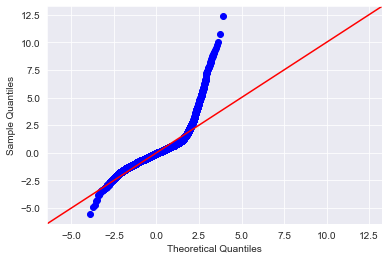

In [115]:
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

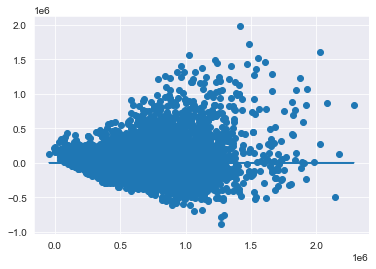

In [116]:
plt.scatter(model.predict(fin_x), model.resid)
plt.plot(model.predict(fin_x), [0 for i in range(len(final))])

# Log Transformation of Price 
Testing out model performance after performing log transformation on target variable 'price'

In [117]:
final['price'] = final['price'].map(lambda x : np.log(x))

In [118]:
final = final.rename({'price':'log_price'}, axis=1)

In [119]:
# remodeling
target = 'log_price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
======================================================================================
Model:                     OLS                    Adj. R-squared:           0.777     
Dependent Variable:        log_price              AIC:                      -1280.4411
Date:                      2021-03-02 15:59       BIC:                      -1034.9913
No. Observations:          20287                  Log-Likelihood:           671.22    
Df Model:                  30                     F-statistic:              2359.     
Df Residuals:              20256                  Prob (F-statistic):       0.00      
R-squared:                 0.777                  Scale:                    0.054885  
--------------------------------------------------------------------------------------
                                    Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------------------
Intercept                          -33.7454   2.5760 -13.0999 0.0000 -38.7945 -28.6962
grd_6_to_7                          -0.1498   0.0047 -32.0697 0.0000  -0.1590  -0.1407
bathrooms                            0.0581   0.0042  13.8822 0.0000   0.0499   0.0663
log_sqft_living15                    0.0842   0.0028  30.1680 0.0000   0.0787   0.0896
lat                                  0.5146   0.0229  22.4592 0.0000   0.4697   0.5595
waterfront_Y                         0.5524   0.0235  23.4759 0.0000   0.5063   0.5985
yr_built                            -0.0027   0.0001 -31.0024 0.0000  -0.0029  -0.0025
grd_10_to_11                         0.1856   0.0087  21.4329 0.0000   0.1686   0.2026
grd_12_to_13                         0.3378   0.0403   8.3813 0.0000   0.2588   0.4168
viewed                               0.1424   0.0065  21.9392 0.0000   0.1297   0.1551
log_sqft_above                       0.0983   0.0098   9.9790 0.0000   0.0790   0.1176
has_basement                         0.0443   0.0077   5.7251 0.0000   0.0291   0.0595
log_sqft_lot15                      -0.0274   0.0041  -6.6979 0.0000  -0.0354  -0.0194
zipcode                             -0.0013   0.0001 -12.0882 0.0000  -0.0016  -0.0011
cond_average                        -0.0609   0.0042 -14.5775 0.0000  -0.0691  -0.0527
long                                -0.1849   0.0190  -9.7457 0.0000  -0.2221  -0.1477
cond_very_good                       0.0610   0.0068   9.0020 0.0000   0.0477   0.0743
grd_1_to_5                          -0.3329   0.0170 -19.6237 0.0000  -0.3662  -0.2997
day_of_year                         -0.0002   0.0000 -10.2510 0.0000  -0.0002  -0.0001
bedrooms                            -0.0226   0.0026  -8.6557 0.0000  -0.0277  -0.0175
is_renovated                         0.0184   0.0041   4.5234 0.0000   0.0104   0.0264
floors_3                             0.0439   0.0099   4.4212 0.0000   0.0244   0.0634
log_total_home_sqft                  0.0845   0.0099   8.5547 0.0000   0.0651   0.1039
log_sqft_lot                         0.0006   0.0041   0.1389 0.8896  -0.0076   0.0087
cond_poor                           -0.2857   0.0455  -6.2720 0.0000  -0.3749  -0.1964
cond_fair                           -0.1918   0.0199  -9.6590 0.0000  -0.2307  -0.1529
quad_1                               0.0770   0.0128   6.0208 0.0000   0.0519   0.1021
quad_3                              -0.2795   0.0131 -21.3546 0.0000  -0.3051  -0.2538
log_sqft_above:log_total_home_sqft   0.0147   0.0029   5.0697 0.0000   0.0090   0.0204
bathrooms:log_total_home_sqft       -0.0010   0.0040  -0.2572 0.7970  -0.0089   0.0069
bathrooms:log_sqft_above             0.0133   0.0042   3.1659 0.0015   0.0051   0.0215
--------------------------------------------------------------------------------------
Omnibus:                    450.778             Durbin-Watson:                1.317   
Prob(Omnibus):              0.000               Jarque-Bera (JB)

In [120]:
x_cols = fin_x
y = final['log_price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [121]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [122]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.05474978310183419
Test Mean Squarred Error: 0.05513326924154672


## Calculating Price in Terms of Dollars

In [123]:
# inversing the Log transformation on predictions vs. actual to compare RMSE
real_y_hat_test = np.exp(y_hat_test)
real_y_test = np.exp(y_test)

In [124]:
mse_test = np.sum((real_y_test - real_y_hat_test)**2)/len(real_y_test)
round(np.sqrt(mse_test),2)

152100.67

Our RMSE with the log transformation on price has dropped considerably.  The model is capable of predicting a house price within $148,000.  

Let's look at the QQ-plot and check for homoscedasticity.

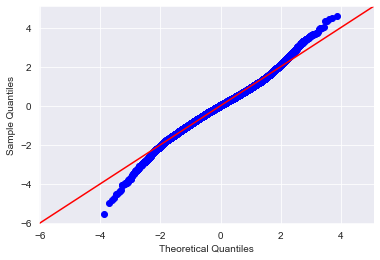

In [125]:
# Checking the residual errors
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

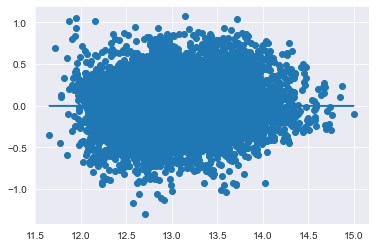

In [126]:
plt.scatter(model.predict(fin_x), model.resid)
plt.plot(model.predict(fin_x), [0 for i in range(len(final))])

# Analysis

According to the model, the following variables have the strongest impact on a home's price in King County:

* The grade that King County gave the home, especially if it was above a 9. This is a separate grading system established by King County that is separate from the condition of the home.  

* Location. Specifically whether or not you live in Quadrant 1, the Bellevue area.

* Whether or not you live on the waterfront.  Aside from paying to have a beautiful view, this could also be because most of the waterfront property is in the northeast section of King County (Quadrant 1). Strangely though, this appears to have a negative effect on the price, with a slope of -1 million.

This model still has a long way to go.  It is consistent, but there are still too many outliers and the residuals are not adhering to the assumptions of normality.  

In its current state, the model is only acceptable for estimating the more expensive homes in King County.